# ***THIS CODE DOES NOT ACTUALLY RUN ON GPUS

In [1]:
!nvidia-smi

Fri May  5 16:14:58 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 6000                 On | 00000000:1B:00.0 Off |                  Off |
| 33%   26C    P8                9W / 260W|      1MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf 
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from time import time
from Loader import train_data_vgg16
import matplotlib.pyplot as plt

2023-05-05 16:14:58.924732: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.operation_timeout_in_ms=60000
sess = tf.compat.v1.Session(config=config)

2023-05-05 16:15:00.605971: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-05 16:15:00.612955: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-05 16:15:00.614034: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-05 16:15:01.894077: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-05 16:15:01.894705: I tensorflow/core/common_runtime/gpu/gpu_devic

In [4]:
####################################################################
# Following code releases unused GPU memory for others to use.
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
####################################################################

2023-05-05 16:15:05.541309: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-05 16:15:05.541958: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-05 16:15:05.542473: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:1c:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-05 16:15:05.542968: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:1d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-05 16:15:05.5

In [5]:
df = train_data_vgg16()
df.head()

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,class
0,27.489744,0.0,0.000000,0.000000,0.000000,4.406033,0.000000,0.000000,0.0,9.508491,...,0.000000,0.0,0.0,0.0,3.239264,5.528229,0.0,0.0,0.00000,Real
1,0.000000,0.0,0.000000,27.298634,0.000000,21.718521,17.454420,0.000000,0.0,14.870244,...,0.000000,0.0,0.0,0.0,0.000000,22.730530,0.0,0.0,0.00000,Real
2,0.000000,0.0,0.000000,0.000000,0.000000,7.493243,0.000000,1.344108,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,Real
3,0.000000,0.0,29.934219,39.067970,0.000000,24.231049,6.911931,0.000000,0.0,0.000000,...,16.403683,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,17.57489,Real
4,0.000000,0.0,0.000000,24.634619,26.340034,0.000000,0.000000,0.000000,0.0,0.000000,...,13.876423,0.0,0.0,0.0,0.000000,28.267170,0.0,0.0,0.00000,Real


In [6]:
df_sample = df.sample(frac=1.0, random_state=0)

In [7]:
X = df_sample.drop('class', axis=1)
y = df_sample['class']
X.head()

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
3582,0.000000,0.0,0.0,0.000000,4.260871,18.161793,0.0,0.000000,0.0,20.675310,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000
10498,32.219925,0.0,0.0,24.435274,0.000000,0.000000,0.0,2.313794,0.0,10.794803,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000
3227,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,65.122879
21333,22.872917,0.0,0.0,0.000000,30.738342,34.451023,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000
3885,28.040337,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,65.730591,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50366,0.000000


## Grid search just number of estimators

In [8]:
B = np.arange(20, 520, 20)
grid = {'n_estimators': B}

tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
    time_start = time()
    
    rf = RandomForestClassifier()
    rfCV1 = GridSearchCV(rf, param_grid=grid, return_train_score=True, n_jobs = -1, verbose=2)
    rfCV1.fit(X, y)
    
    time_stop = time()
    print('Elapsed Time for Random Forest:', time_stop - time_start)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


2023-05-05 16:15:10.581095: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-05 16:15:10.581928: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-05 16:15:10.582485: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:1c:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-05 16:15:10.582976: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:1d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-05 16:15:10.5

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ....................................n_estimators=20; total time=  25.6s
[CV] END ...................................n_estimators=200; total time= 4.1min
[CV] END ...................................n_estimators=400; total time= 7.6min
[CV] END ....................................n_estimators=40; total time=  50.5s
[CV] END ...................................n_estimators=240; total time= 4.9min
[CV] END ...................................n_estimators=420; total time= 7.4min
[CV] END ....................................n_estimators=20; total time=  28.1s
[CV] END ...................................n_estimators=220; total time= 4.7min
[CV] END ...................................n_estimators=420; total time= 7.9min
[CV] END ....................................n_estimators=60; total time= 1.2min
[CV] END ...................................n_estimators=240; total time= 4.9min
[CV] END ...................................n_e

In [9]:
rfCV1.best_score_

0.8690300000000001

In [10]:
rfCV1.best_params_

{'n_estimators': 460}

<AxesSubplot: title={'center': 'Number of Trees vs Error'}, xlabel='Trees'>

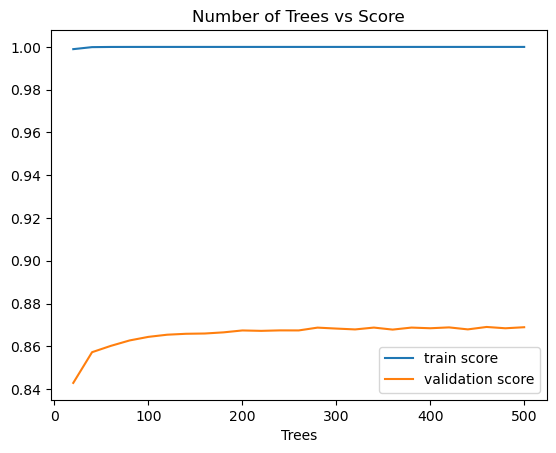

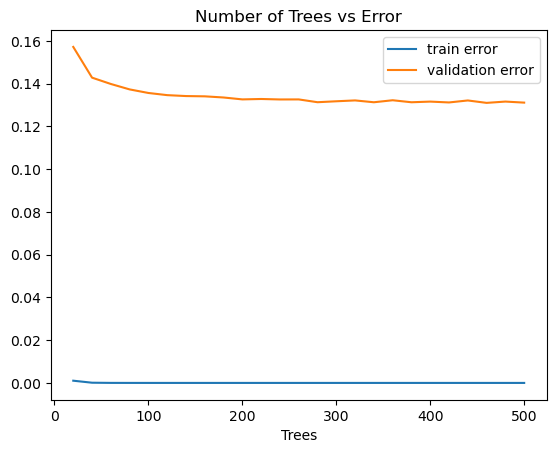

In [11]:
results = pd.DataFrame()
results['Trees'] = grid['n_estimators']
results['train error'] = 1 - rfCV1.cv_results_['mean_train_score']
results['validation error'] = 1 - rfCV1.cv_results_['mean_test_score']
results['train score'] = rfCV1.cv_results_['mean_train_score']
results['validation score'] = rfCV1.cv_results_['mean_test_score']

results.plot.line(x = 'Trees', y = ['train score', 'validation score'], title='Number of Trees vs Score')
results.plot.line(x = 'Trees', y = ['train error', 'validation error'], title='Number of Trees vs Error')

## Grid Search both hyperparams

In [12]:
B = np.arange(20, 320, 20)
depth = np.arange(12, 532, 50)
grid = {'n_estimators': B, 'max_depth': depth}

tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
    time_start = time()
    
    rf = RandomForestClassifier()
    rfCV2 = GridSearchCV(rf, param_grid=grid, return_train_score=True, n_jobs = -1, verbose=2)
    rfCV2.fit(X, y)
    
    time_stop = time()
    print('Elapsed Time for Random Forest:', time_stop - time_start)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
Fitting 5 folds for each of 165 candidates, totalling 825 fits
[CV] END .....................max_depth=12, n_estimators=180; total time= 2.1min
[CV] END .....................max_depth=62, n_estimators=100; total time= 2.1min
[CV] END .....................max_depth=62, n_estimators=260; total time= 5.6min


/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END .....................max_depth=12, n_estimators=160; total time= 1.7min
[CV] END ......................max_depth=62, n_estimators=40; total time=  48.5s
[CV] END .....................max_depth=62, n_estimators=140; total time= 2.8min
[CV] END .....................max_depth=112, n_estimators=20; total time=  25.3s
[CV] END .....................max_depth=112, n_estimators=60; total time= 1.2min
[CV] END ....................max_depth=112, n_estimators=140; total time= 2.9min
[CV] END ....................max_depth=112, n_estimators=280; total time= 5.7min
[CV] END ......................max_depth=12, n_estimators=80; total time=  53.1s
[CV] END .....................max_depth=12, n_estimators=280; total time= 3.0min
[CV] END .....................max_depth=62, n_estimators=240; total time= 4.9min
[CV] END ....................max_depth=112, n_estimators=220; total time= 4.5min
[CV] END ....................max_depth=162, n_estimators=180; total time= 3.7min
[CV] END ...................

In [13]:
rfCV2.best_score_

0.86884

In [14]:
rfCV2.best_params_

{'max_depth': 262, 'n_estimators': 300}

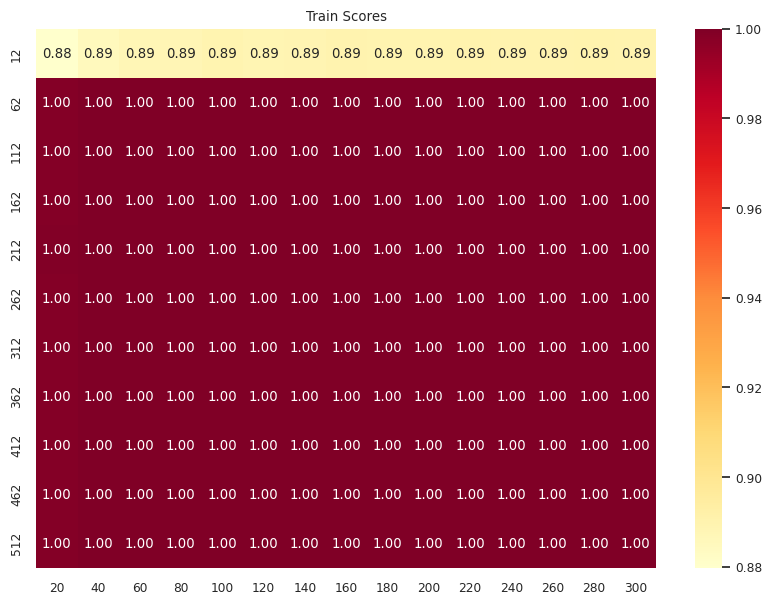

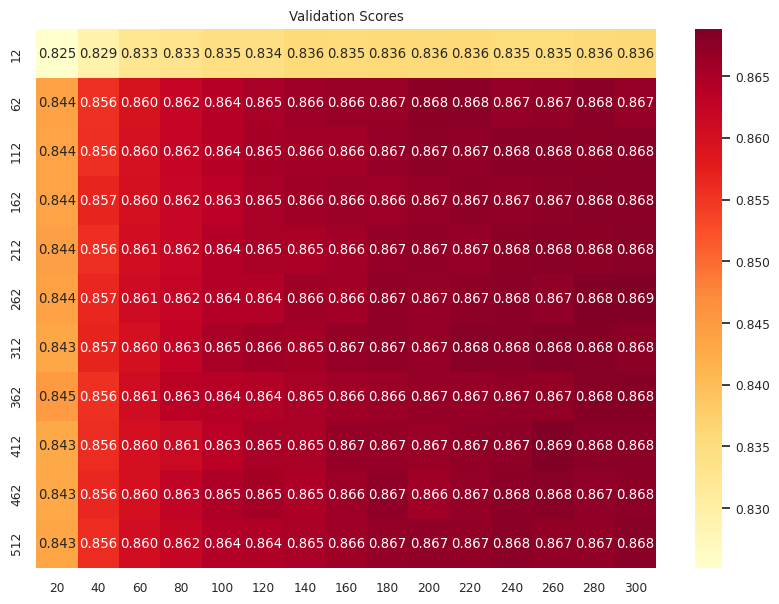

In [30]:
# Extract the hyperparameters, scores, and create a results dataframe
results = pd.DataFrame(rfCV2.cv_results_)
max_depths = results['param_max_depth'].unique()
n_estimators = results['param_n_estimators'].unique()
train = np.array(results['mean_train_score']).reshape(len(max_depths), len(n_estimators))
valid = np.array(results['mean_test_score']).reshape(len(max_depths), len(n_estimators))

# Create a heatmap of the results
sns.set(style='whitegrid', font_scale=.8)
fig, ax = plt.subplots(figsize=(10, 7))
ax.set(xlabel='Number of Trees', ylabel='Max Depth', title='Train Scores')
sns.heatmap(train, annot=True, fmt='.2f', cmap='YlOrRd', xticklabels=n_estimators, yticklabels=max_depths)
plt.show()

sns.set(style='whitegrid', font_scale=.8)
fig, ax = plt.subplots(figsize=(10, 7))
ax.set(xlabel='Number of Trees', ylabel='Max Depth', title='Validation Scores')
sns.heatmap(valid, annot=True, fmt='.3f', cmap='YlOrRd', xticklabels=n_estimators, yticklabels=max_depths)
plt.show()

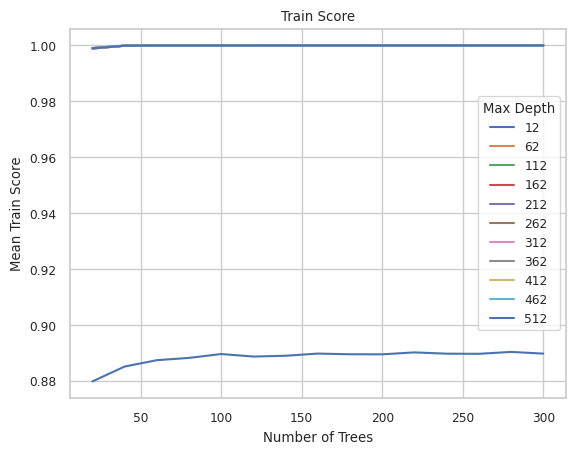

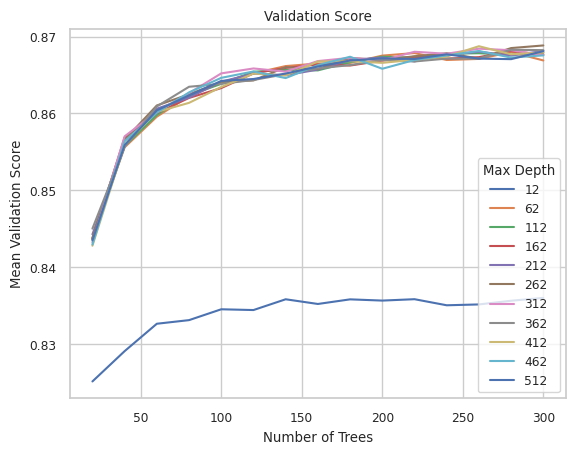

In [32]:
# Get the hyperparameter values and corresponding scores
max_depths = grid['max_depth']
n_estimators = grid['n_estimators']

train = rfCV2.cv_results_['mean_train_score'].reshape(len(max_depths), len(n_estimators))
valid = rfCV2.cv_results_['mean_test_score'].reshape(len(max_depths), len(n_estimators))

# Plot the scores against the hyperparameters
fig, ax = plt.subplots()
ax.set(xlabel='Number of Trees', ylabel='Mean Train Score', title='Train Score')
for i, depth in enumerate(max_depths):
    ax.plot(n_estimators, train[i], label=depth)
ax.legend(title='Max Depth')
plt.show()

fig, ax = plt.subplots()
ax.set(xlabel='Number of Trees', ylabel='Mean Validation Score', title='Validation Score')
for i, depth in enumerate(max_depths):
    ax.plot(n_estimators, valid[i], label=depth)
ax.legend(title='Max Depth')
plt.show()